In [132]:
import pandas as pd
import numpy as np
from glob import  glob

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import json
import matplotlib.pyplot as plt

import xarray as xr

In [133]:
target_time = pd.date_range('19910101','20201231',freq='d')
df_times = pd.DataFrame({'index': target_time}, index=target_time)
paths = glob('data/raw/*')

def fix_name(d):
    return d.split(':')[-1].replace('\n','')[1:]

dfs = list()
for p in paths:
    
    with open(p) as file:
        data = file.readlines()
        names = ['name', 'cod', 'lat', 'lon', 'alt', 'status', 'init_at', 'end_at', 'freq']
        values = [fix_name(d) for d in data[:9]]
        cfg = dict(zip(names, values))

    df = pd.read_csv(p, sep=';', na_values=['-9999.0','null'], skiprows=9)

    for name, value in cfg.items():
        df[name] = value
    
    df.index = pd.to_datetime(df['Data Medicao'].values)
    df = df.loc['1991-01-01':'2020-12-31']
    df[(df.index.day==29) & (df.index.month==2)] = np.nan
    df_combined = df_times.combine_first(df)
    main_df = df_combined[['TEMPERATURA MEDIA COMPENSADA, DIARIA(°C)']]

    total = len(main_df)
    total_nan = len(main_df) - len(main_df.dropna())
    percent_null = total_nan/total * 100
    
    df_combined['percent_null'] = round(float(percent_null), 1)
    df_combined = df_combined.sort_values('index')

    if percent_null < 12:       
        dfs.append(df_combined)  

df_concat = pd.concat(dfs)

codes = df_concat.cod.dropna().unique()
names = [df_concat[df_concat.cod==code].name.iloc[0] for code in codes]
lons = [float(df_concat[df_concat.cod==code].lon.iloc[0]) for code in codes]
lats = [float(df_concat[df_concat.cod==code].lat.iloc[0]) for code in codes]
alt = [float(df_concat[df_concat.cod==code].alt.iloc[0]) for code in codes]
percent_null = [float(df_concat[df_concat.cod==code].percent_null.iloc[0]) for code in codes]
cidades = pd.DataFrame(dict(names=names, lons=lons, lats=lats, alt=alt, codes=codes, percent_null=percent_null))

In [134]:
dfs = list()
for i, code in enumerate(codes):
    df_code = df_concat[df_concat['cod']==code]
    df_code = df_times.combine_first(df_code)
    info = df_code.iloc[:, [-1, -3, -10]]
    df_code = df_code.assign(tmean=df_code['TEMPERATURA MEDIA COMPENSADA, DIARIA(°C)'])
    #df_code.assign(tmean=df_code.iloc[:, [4,6]].mean(axis=1))
    df_code['tmean'] = df_code['tmean'].fillna(df_code['tmean'].mean())
    df_final = pd.concat([info, df_code['tmean']], axis=1).reset_index()
    _df = pd.DataFrame({code:df_final['tmean'].values}, index=df_final['index']).T
    dfs.append(_df)


data2group = pd.DataFrame([df.values.ravel() for df in dfs], columns=[str(c).split(' ')[0] for c in _df.columns], index=[str(df.index[0]) for df in dfs])
data2group = data2group.reset_index()
idx2code = data2group['index'].to_dict()

data = data2group.iloc[:, 1:]
#data.iloc[8,:] = data.iloc[8,:].fillna(data.iloc[8,:].mean())
#data.iloc[15,:] = data.iloc[8,:].fillna(data.iloc[15,:].mean())

In [135]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Dendograma')
        plt.xlabel('Índices')
        plt.ylabel('Distâncias')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.4g" % round(y,0), (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

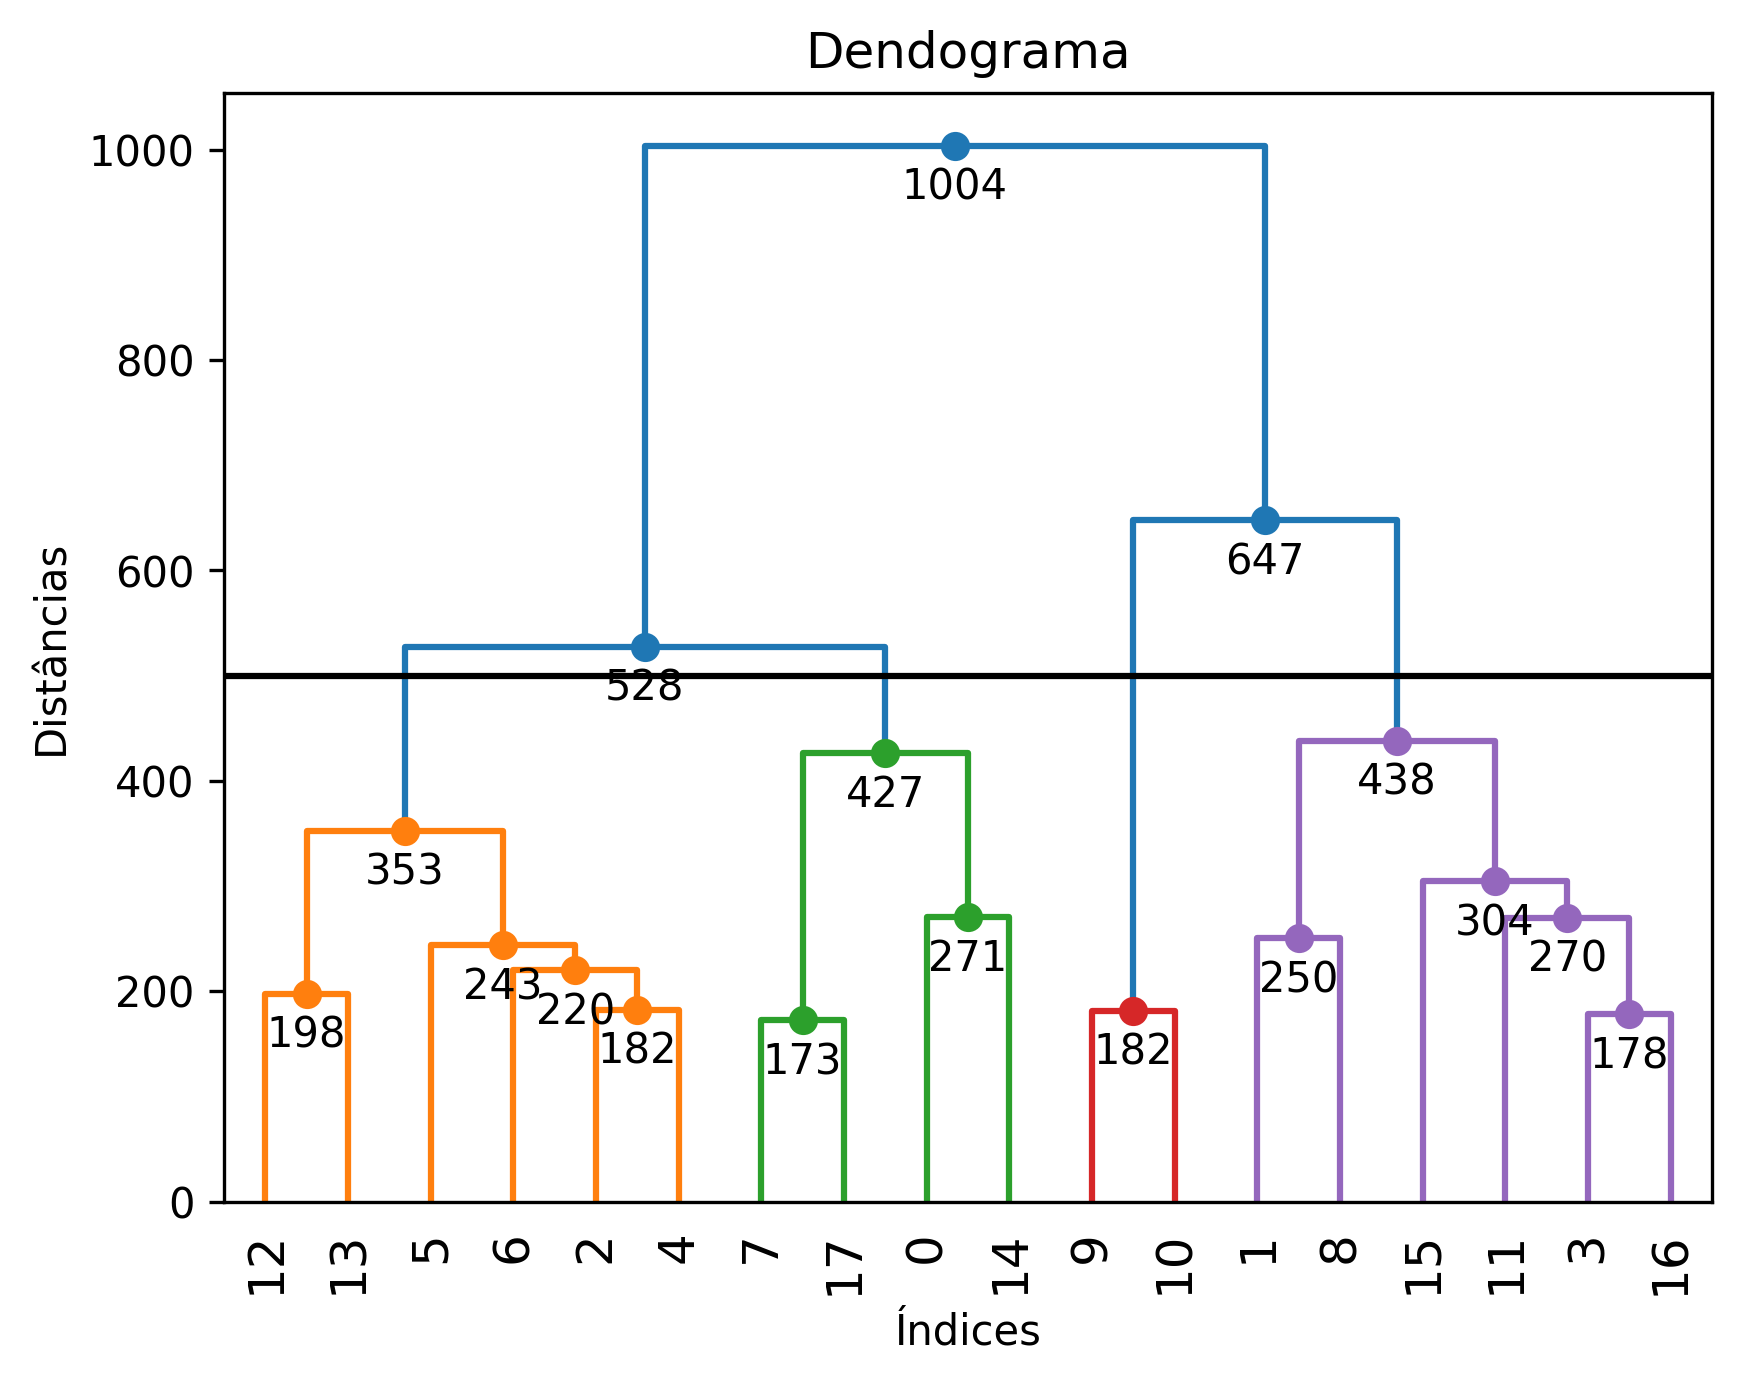

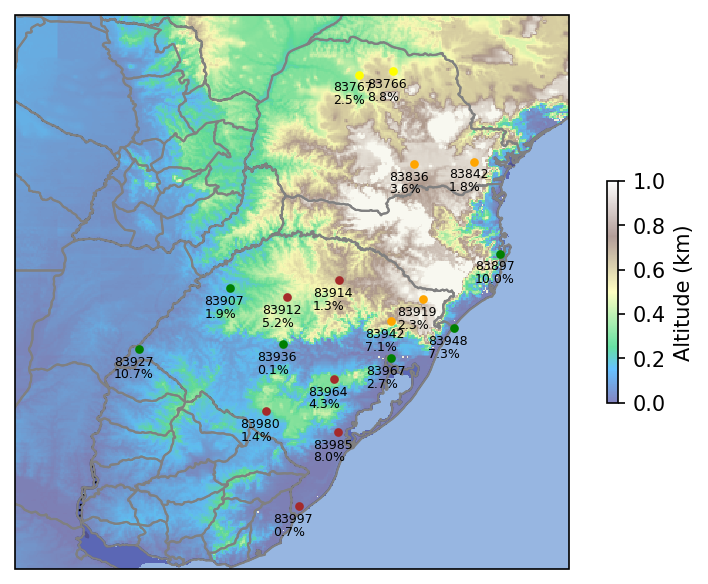

In [139]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster

max_d = 500
Z = linkage(pdist(data.values), 'ward')
clusters = fcluster(Z,max_d,criterion='distance')

fig = plt.figure(dpi=300)
D = fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=max_d,
)
plt.savefig('dendogram.png')
plt.show()

colors = {'C1': 'brown', 'C2': 'orange', 'C3': 'yellow', 'C4': 'green'} #, 'C5': 'brown', 'C6':'pink'}
codes = [idx2code.get(int(ivl)) for ivl in D['ivl']]
groups = D['leaves_color_list']
codes2group = dict(zip(codes, groups))
codes2color = {k:colors.get(v) for k, v in codes2group.items()}

def get_groups(group):
    return [k for k, v in codes2group.items() if v == group]

g1 = np.nanmean([data2group[data2group['index'] == g].iloc[:,1:].values[0] for g in get_groups('C1')], axis=0)
g2 = np.nanmean([data2group[data2group['index'] == g].iloc[:,1:].values[0] for g in get_groups('C2')], axis=0)
g3 = np.nanmean([data2group[data2group['index'] == g].iloc[:,1:].values[0] for g in get_groups('C3')], axis=0)
g4 = np.nanmean([data2group[data2group['index'] == g].iloc[:,1:].values[0] for g in get_groups('C4')], axis=0)

etopo = xr.open_dataset("/media/lucaspc/HD/statics/etopo_0p01.nc")
etopo = xr.where(etopo<0, np.nan, etopo)
etopo = xr.where(etopo>1000, 1000, etopo)

fig = plt.figure(dpi=150)

ax = plt.axes(projection=ccrs.PlateCarree())
extent = [-60, -47, -35, -22]
ax.set_extent(extent, crs=ccrs.PlateCarree())


ax.add_feature(cfeature.LAND, edgecolor='gray')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.OCEAN, edgecolor='gray')
ax.add_feature(cfeature.STATES, edgecolor='gray')
etopo = etopo['z'] / 1000
cb = etopo.plot(ax=ax, cmap='terrain', alpha=0.6, add_colorbar=False)
plt.colorbar(cb, ax=ax, label='Altitude (km)', shrink=0.4)

marker = 'o'
for idx, row in cidades.iterrows():
    
    color = codes2color.get(row['codes'])
        
    ax.scatter(row['lons'], row['lats'], transform=ccrs.PlateCarree(),
          color=color, s=10, zorder=5, marker=marker)
    ax.text(row['lons']-0.6, row['lats']-0.6, str(row['percent_null']) + '%',
            transform=ccrs.PlateCarree(),
            fontsize=6, 
            color='black', zorder=100,
            verticalalignment='center')
    ax.text(row['lons']-0.6, row['lats']-0.3, row['codes'],
            transform=ccrs.PlateCarree(),
            fontsize=6,
            color='black',
            verticalalignment='center')

plt.savefig('stations.png')
plt.show()

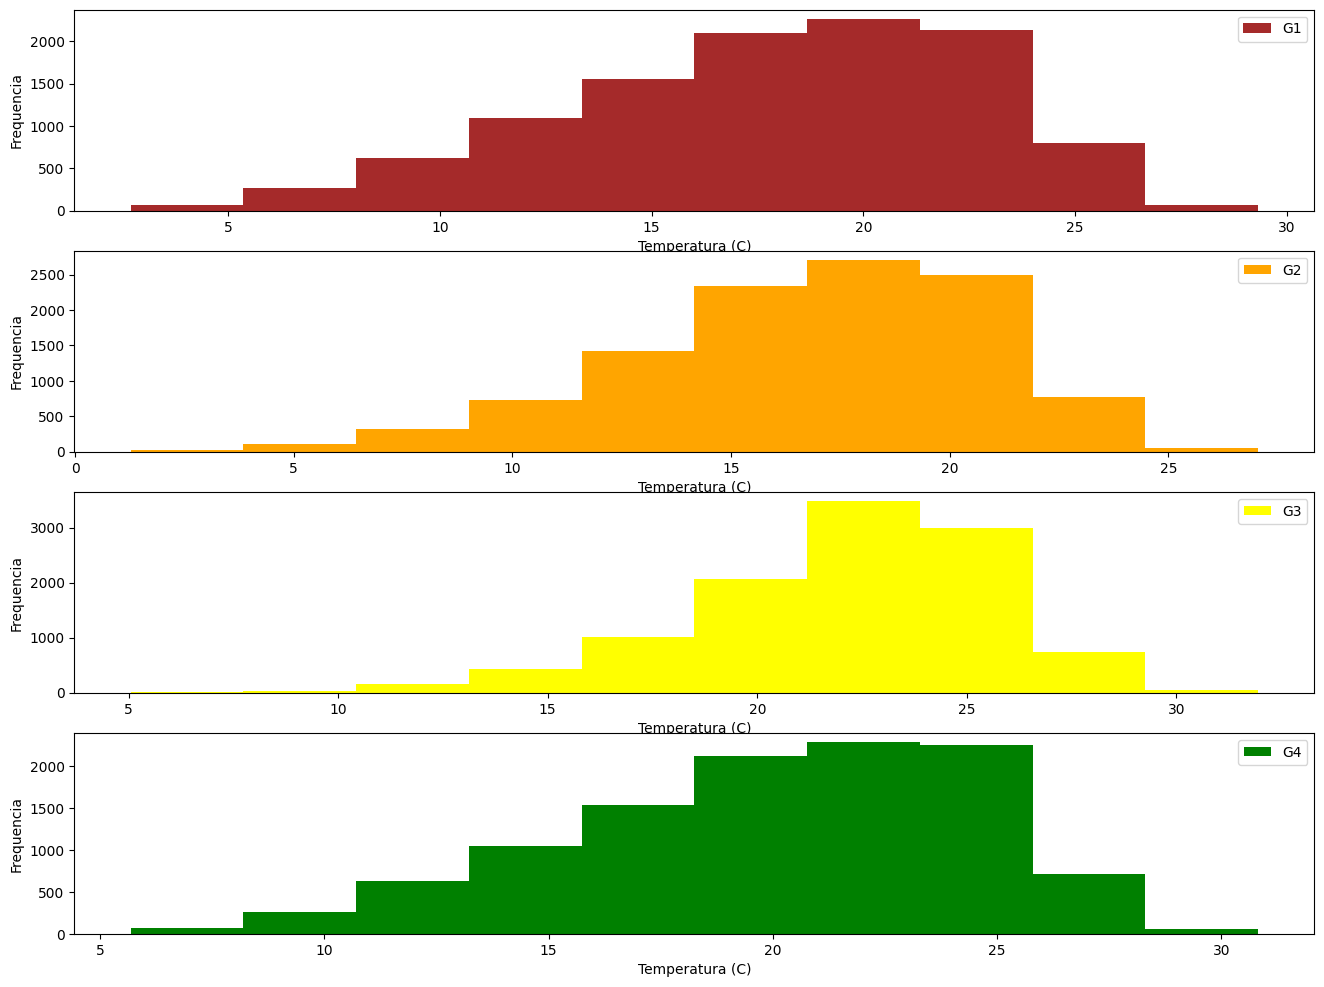

In [137]:
df_groups = pd.DataFrame({'G1':g1,'G2':g2,'G3':g3,'G4':g4})
fig, ax = plt.subplots(4,1, figsize=(16,12))
df_groups['G1'].plot.hist(ax=ax[0], subplots=True, figsize=(14,8), ylabel='Frequencia', xlabel='Temperatura (C)', label='G1', color=colors.get('C1'));
df_groups['G2'].plot.hist(ax=ax[1], subplots=True, figsize=(14,8), ylabel='Frequencia', xlabel='Temperatura (C)', label='G2', color=colors.get('C2'));
df_groups['G3'].plot.hist(ax=ax[2], subplots=True, figsize=(14,8), ylabel='Frequencia', xlabel='Temperatura (C)', label='G3', color=colors.get('C3'));
df_groups['G4'].plot.hist(ax=ax[3], subplots=True, figsize=(14,8), ylabel='Frequencia', xlabel='Temperatura (C)', label='G4', color=colors.get('C4'));
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()
plt.savefig('histo.png')

In [138]:
data.groupby(by='label').mean()

KeyError: 'label'

In [ ]:
data

In [ ]:
_data = whiten(data.values)
centroids, mean_value = kmeans(_data, 3)

print("centroids:\n", centroids, "\n")
print("Mean of Euclidean distances :",  mean_value.round(4))

centroids:
 [[ 7.00487082  6.06001861  6.41155944 ...  8.35866724  9.08521439
  10.46099071]
 [ 7.64880944  6.97692438  7.63239147 ...  8.3514212   9.11213072
  11.93770169]
 [ 8.31557876  7.23247051  8.18519045 ...  9.34687351  9.76661729
  11.54288803]] 

Mean of Euclidean distances : 69.1081


In [ ]:
# def EHF(df):
#     p95 = df['TEMPERATURA MEDIA COMPENSADA, DIARIA(°C)'].quantile(0.95)
#     data = list()
#     for i in range(29, len(df['TEMPERATURA MEDIA COMPENSADA, DIARIA(°C)'])):
#         try:
#             time = df.index[i+3]
#             temperature_mean = df['TEMPERATURA MEDIA COMPENSADA, DIARIA(°C)'].iloc[i+3]
#             last3days = df['temperature_mean'].iloc[i:i+3]
#             last30days = df['temperature_mean'].iloc[i-29:i]
            
#             ehfsig = last3days.mean() - p95
#             ehfacl = last3days.mean() - last30days.mean()
        
#             #print(i)
#             #print((i,i+3))
#             #print(last3days)
#             #print((i-29,i))
#             #print(last30days)
#             #print(time)
            
#             EHF = max(0, ehfsig) * max(1, ehfacl)
#             data.append({
#                 'time':time, 'temperature_mean':temperature_mean, 'ehfsig':ehfsig, 'ehfacl':ehfacl, 'EHF':EHF
#             })

#         except:
#             pass
#     df_ehf = pd.DataFrame(data)
#     df_ehf.index = df_ehf.time
#     df_ehf['severity'] = df_ehf[df_ehf.EHF>0]['EHF'] / df_ehf[df_ehf.EHF>0]['EHF'].quantile(0.85)
#     return df_ehf

p95 = df_concat['TEMPERATURA MEDIA COMPENSADA, DIARIA(°C)'].quantile(0.95)
data = list()
for i in range(29, len(df_concat['TEMPERATURA MEDIA COMPENSADA, DIARIA(°C)'])):
    time = df_concat.index[i+3]
    temperature_mean = df_concat['TEMPERATURA MEDIA COMPENSADA, DIARIA(°C)'].iloc[i+3]
    last3days = df_concat['TEMPERATURA MEDIA COMPENSADA, DIARIA(°C)'].iloc[i:i+3]
    last30days = df_concat['TEMPERATURA MEDIA COMPENSADA, DIARIA(°C)'].iloc[i-29:i]
    
    ehfsig = last3days.mean() - p95
    ehfacl = last3days.mean() - last30days.mean()

    #print(i)
    print((i,i+3))
    #print(last3days)
    print((i-29,i))
    #print(last30days)
    print(time)
    
    EHF = max(0, ehfsig) * max(1, ehfacl)
    data.append(pd.DataFrame({
        'time':[time], 'temperature_mean':[temperature_mean], 'ehfsig':[ehfsig], 'ehfacl':[ehfacl], 'EHF':[EHF]
    }))

df_ehf = pd.concat(data)
print(df_ehf)
df_ehf.index = df_ehf.time
df_ehf['severity'] = df_ehf[df_ehf.EHF>0]['EHF'] / df_ehf[df_ehf.EHF>0]['EHF'].quantile(0.85)